In [ ]:
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization


%matplotlib inline

np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
import tensorflow_hub as hub



# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/C1_data/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 84 images belonging to 2 classes.


In [ ]:
train_data_dir = '/content/drive/MyDrive/C1_data/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Generate data paths with labels
test_data_dir = '/content/drive/MyDrive/C1_data/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels',
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


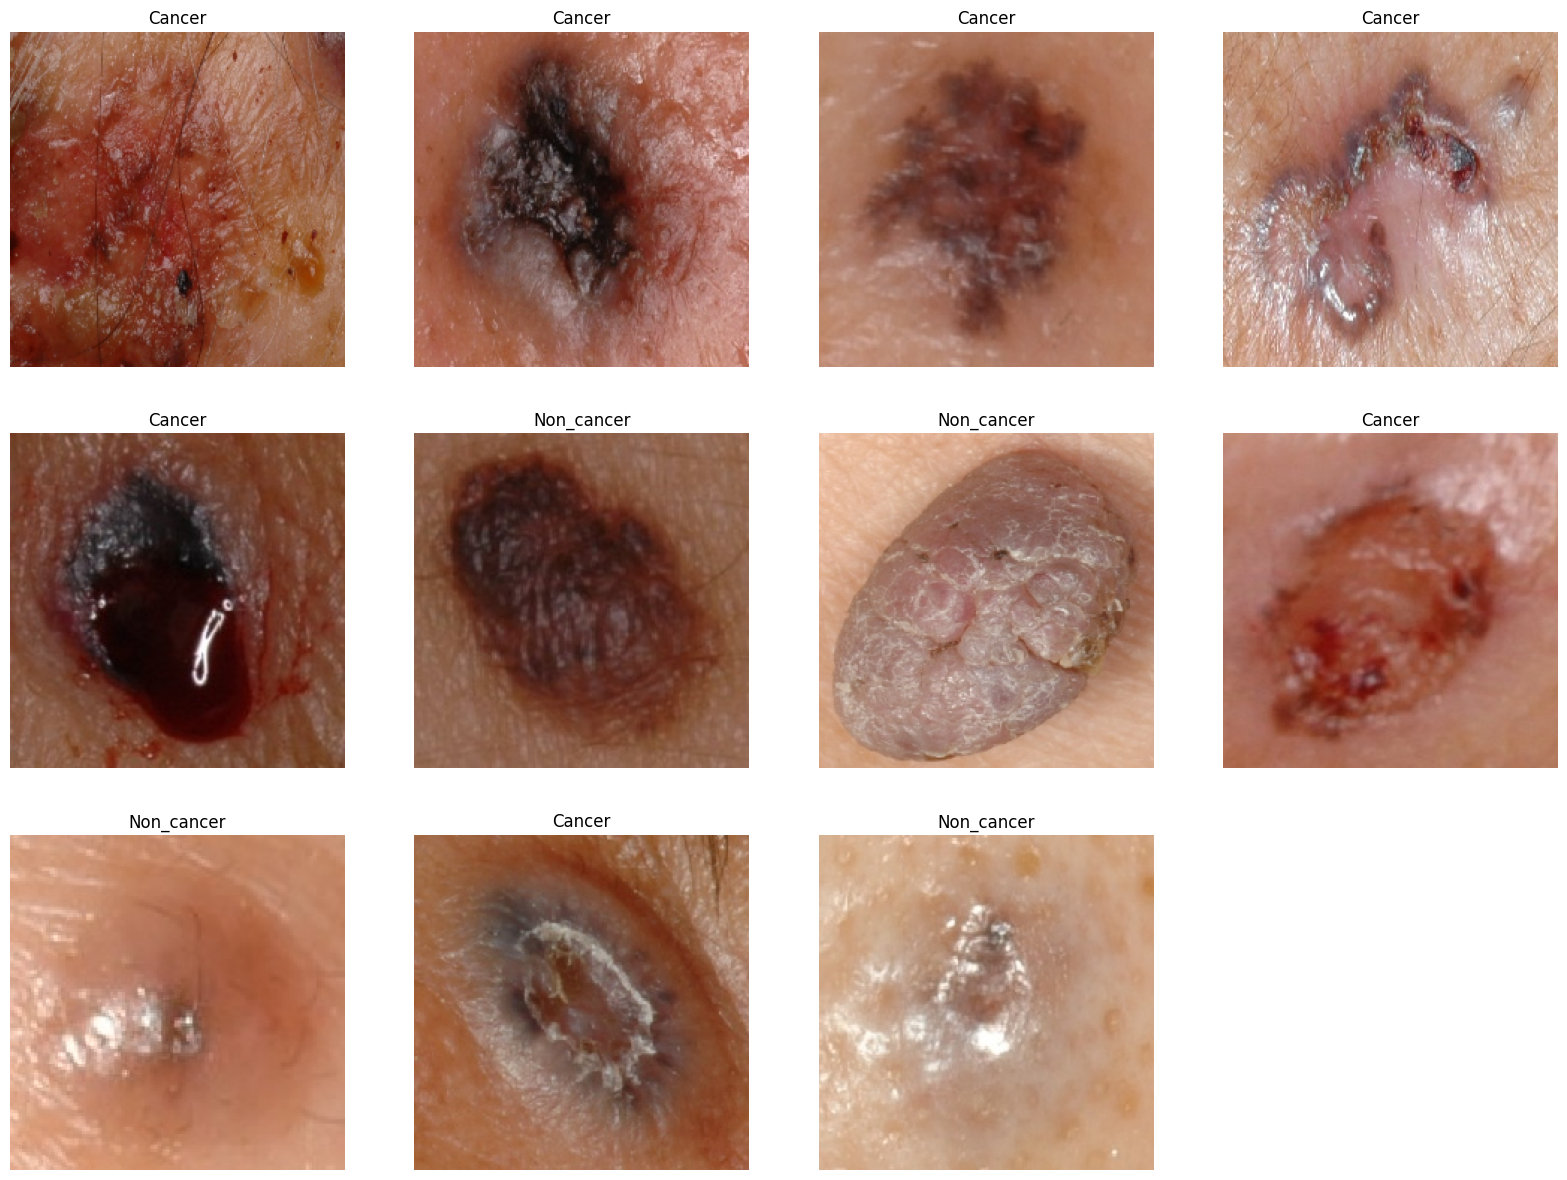

In [ ]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(11):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    if classes[index] == 'Non_Cancer':
        class_name = 'non_cancer'

    elif classes[index] == 'malignant':
        class_name = 'cancer'
    else:
        class_name = classes[index]
    plt.title(class_name, fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,290 (73.50 MB)

 Trainable params: 19,266,306 (73.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_gen,
                    validation_data = test_gen,
                     batch_size = 64,
                    epochs = 50)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.6902 - loss: 0.8828 - val_accuracy: 0.2059 - val_loss: 53.9060
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.7484 - loss: 0.6513 - val_accuracy: 0.2059 - val_loss: 41.0382
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.8941 - loss: 0.3069 - val_accuracy: 0.2059 - val_loss: 26.7063
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.9483 - loss: 0.2159 - val_accuracy: 0.2304 - val_loss: 5.9408
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.8210 - loss: 0.4778 - val_accuracy: 0.2255 - val_loss: 4.6405
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.8824 - loss: 0.3207 - val_accuracy: 0.2304 - val_loss: 5.1493
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.9539 - loss: 0.2022 - val_accuracy: 0.2451 - val_loss: 4.6571
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9838 - loss: 0.0979 - val_accuracy: 0.2647 - val_loss

In [ ]:
Er = []
np.append(history1, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9aecc5c50>],
      dtype=object)

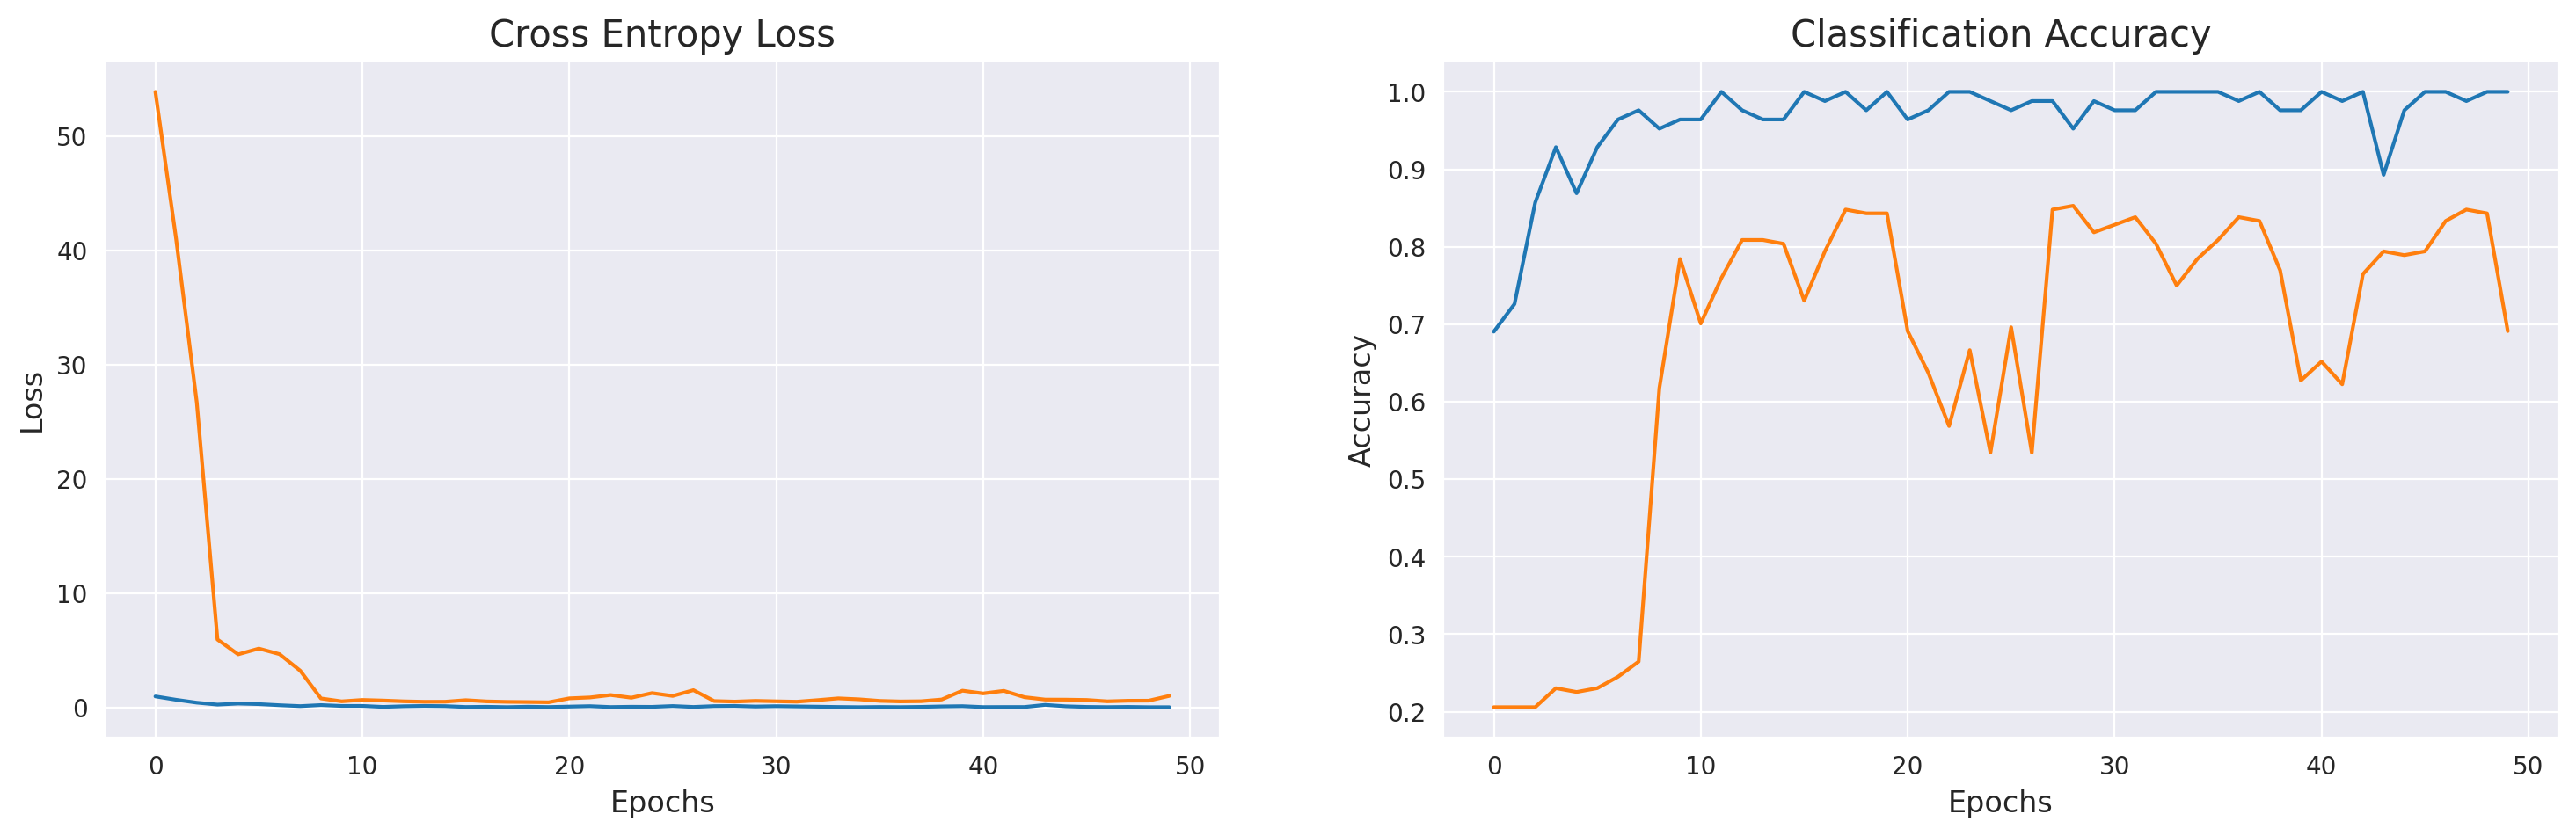

In [ ]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.7207 - loss: 0.5682
The accuracy of the model for training data is: 73.8095223903656
The Loss of the model for training data is: 0.5195513367652893


In [ ]:
Er = []
np.append(history1, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9aecc5c50>],
      dtype=object)

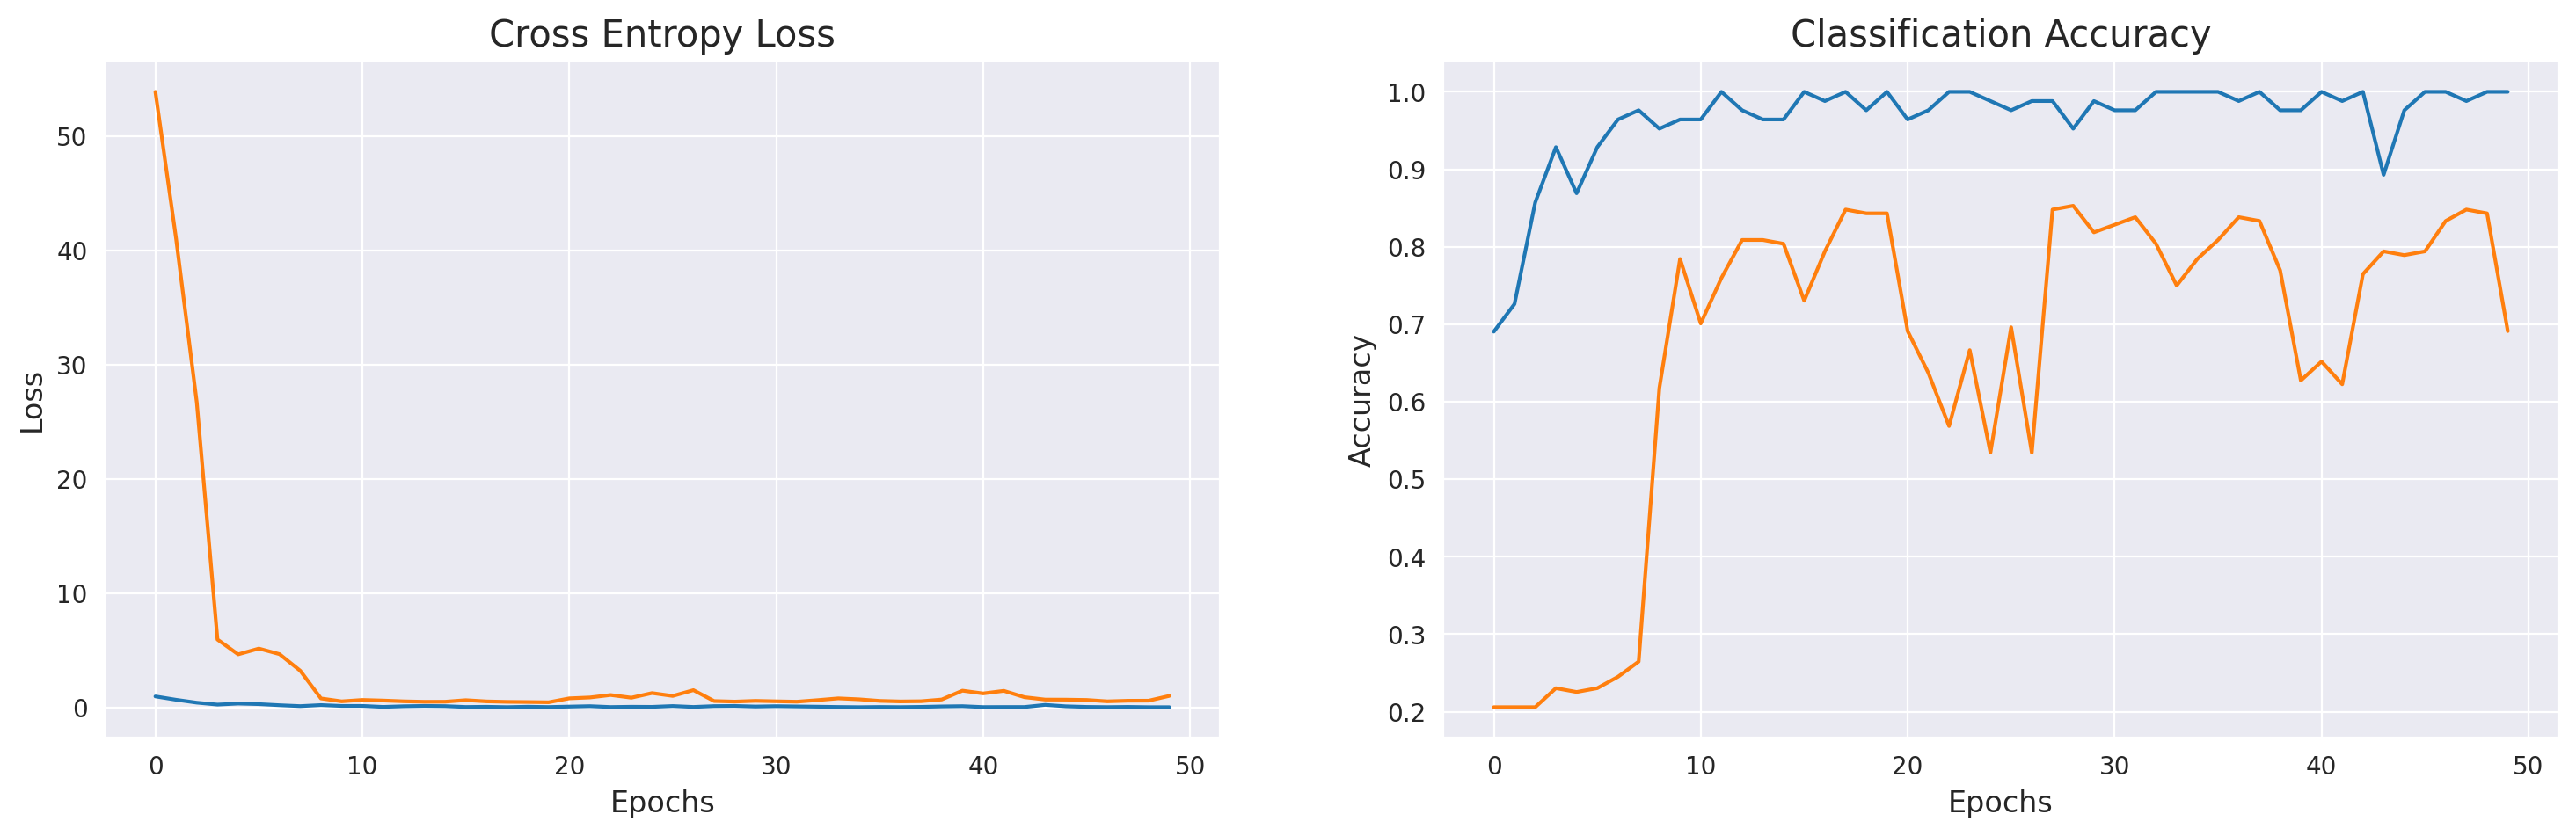

In [ ]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6391 - loss: 1.3240
The accuracy of the model for testing data is: 69.11764740943909
The Loss of the model for testing data is: 1.0035741329193115


In [ ]:
print(classification_report(y_true, y_pred,target_names=classes))

              precision    recall  f1-score   support

      Cancer       0.34      0.55      0.42        42
  Non_cancer       0.86      0.73      0.79       162

    accuracy                           0.69       204
   macro avg       0.60      0.64      0.61       204
weighted avg       0.75      0.69      0.71       204



Resnet50


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [ ]:
history_resnet = model_resnet.fit(train_gen,
                           validation_data=test_gen,
                           batch_size=64,
                           epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.6159 - loss: 0.6602 - val_accuracy: 0.8137 - val_loss: 0.4428
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 402ms/step - accuracy: 0.9434 - loss: 0.1177 - val_accuracy: 0.8578 - val_loss: 0.3845
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.8578 - val_loss: 0.4477
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.9878 - loss: 0.0395 - val_accuracy: 0.8627 - val_loss: 0.3870
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 1.0000 - loss: 0.0321 - val_accuracy: 0.8431 - val_loss: 0.3935
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8480 - val_loss: 0.4289
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.8627 - val_loss: 0.4408
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.8578 - val_loss: 

In [ ]:
Er = []
np.append(history_resnet, Er)

array([<keras.src.callbacks.history.History object at 0x7cc9963a4110>],
      dtype=object)

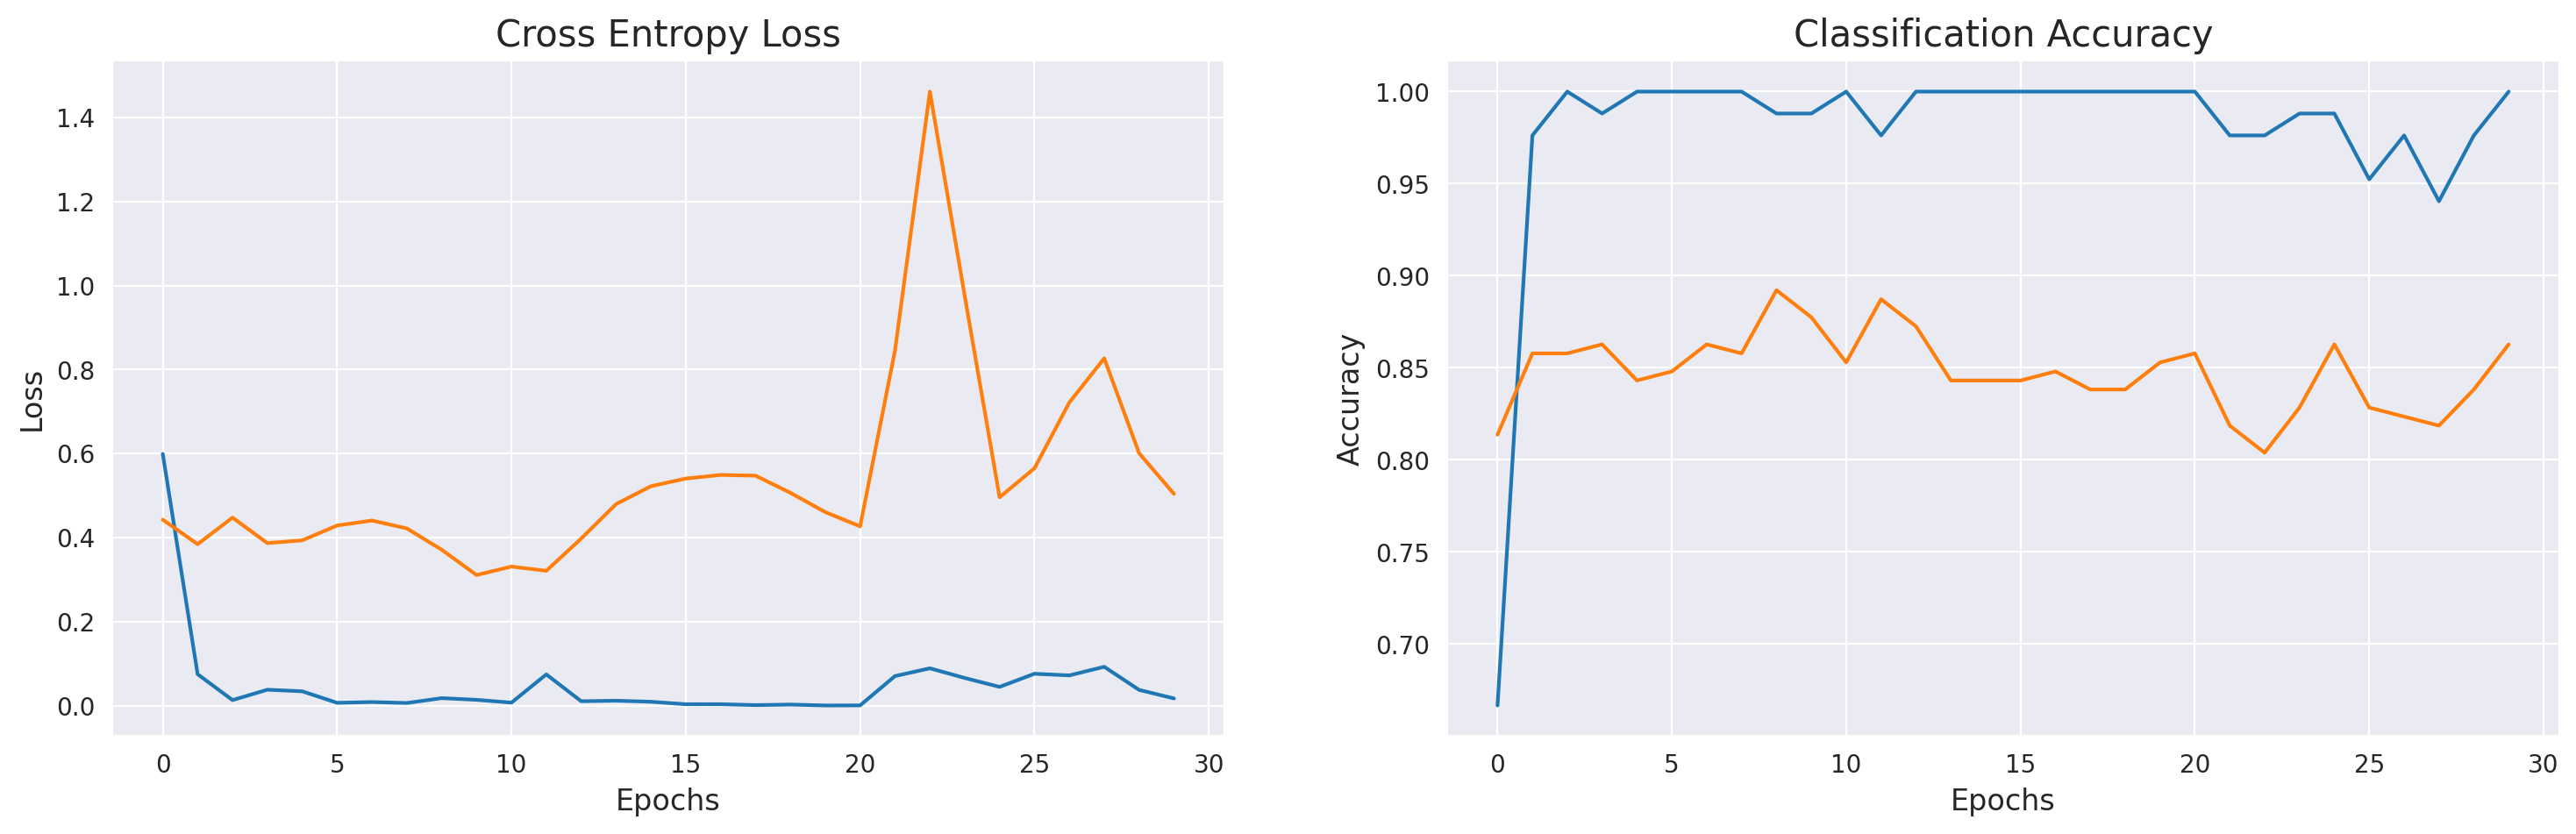

In [ ]:
error_resnet = pd.DataFrame(history_resnet.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_resnet['loss'])
plt.plot(error_resnet['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_resnet['accuracy'])
plt.plot(error_resnet['val_accuracy'])

plt.show()

In [ ]:
# Prediction
result = model_resnet.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels

# Evaluvate
loss,acc = model_resnet.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7445 - loss: 0.9444
The accuracy of the model for testing data is: 86.27451062202454
The Loss of the model for testing data is: 0.5042404532432556


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.13725490196078433


In [ ]:
# After training your model, save it to a file
model_resnet.save('skin_cancer_resnet_model_1.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
#model_resnet = load_model('/content/skin_cancer_resnet_model_1.h5')  # Replace 'your_model_path.h5' with the actual path to your saved model

In [ ]:
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load the test data generator
# test_data_dir = '/kaggle/input/skin-cancer-image-classification/New_Skin_Data_1/Testing'  # Update with your test data path
# ts_gen = ImageDataGenerator(rescale=1./255)  # Normalize the test data
# test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
#                                      target_size=(224, 224), class_mode='categorical',
#                                      color_mode='rgb', shuffle=False, batch_size=1)

# # Get a random image and its label from the test dataset
# random_index = random.randint(0, len(test_gen) - 1)
# random_image, random_label = test_gen[random_index]

# # Make a prediction on the random image
# prediction = model_resnet.predict(random_image)[0]

# # Define class labels
# class_labels = ['Non_cancer', 'Cancer']

# # Get the predicted class and true class
# predicted_class = class_labels[np.argmax(prediction)]
# true_class = class_labels[np.argmax(random_label)]

# # Calculate accuracy
# accuracy = 1 if true_class == predicted_class else 0

# # Display the random image, the prediction, and the accuracy
# plt.imshow(random_image[0])  # No need to divide by 255 as rescaling is done in the generator
# plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}\nAccuracy: {accuracy}')
# plt.show()


VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the pre-trained VGG16 model with ImageNet weights (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of the VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# Create the new model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Data directories and parameters
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

In [ ]:
# Create data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [ ]:
# Train the model
history_vgg16 = model.fit(train_gen,
                         validation_data=test_gen,
                         batch_size=64,
                         epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5195 - loss: 2.2530 - val_accuracy: 0.2157 - val_loss: 1.1310
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 740ms/step - accuracy: 0.5397 - loss: 0.7745 - val_accuracy: 0.7941 - val_loss: 0.4621
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.4807 - loss: 0.9220 - val_accuracy: 0.7647 - val_loss: 0.6198
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.6477 - loss: 0.6370 - val_accuracy: 0.8137 - val_loss: 0.4858
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 737ms/step - accuracy: 0.6020 - loss: 0.7133 - val_accuracy: 0.2696 - val_loss: 0.9667
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.6072 - loss: 0.6464 - val_accuracy: 0.7941 - val_loss: 0.5764
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - accuracy: 0.5602 - loss: 0.6652 - val_accuracy: 0.6618 - val_loss: 0.6462
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 503ms/step - accuracy: 0.7055 - loss: 0.5943 - val_accuracy: 0.8284 - val_loss: 0

In [ ]:
# Make predictions
result = model.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels
# Evaluate
loss, acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6157 - loss: 1.1135
The accuracy of the model for testing data is: 44.60784196853638
The Loss of the model for testing data is: 1.5353326797485352


In [ ]:
Er = []
np.append(history_vgg16, Er)

array([<keras.src.callbacks.history.History object at 0x7cc8c606d7d0>],
      dtype=object)

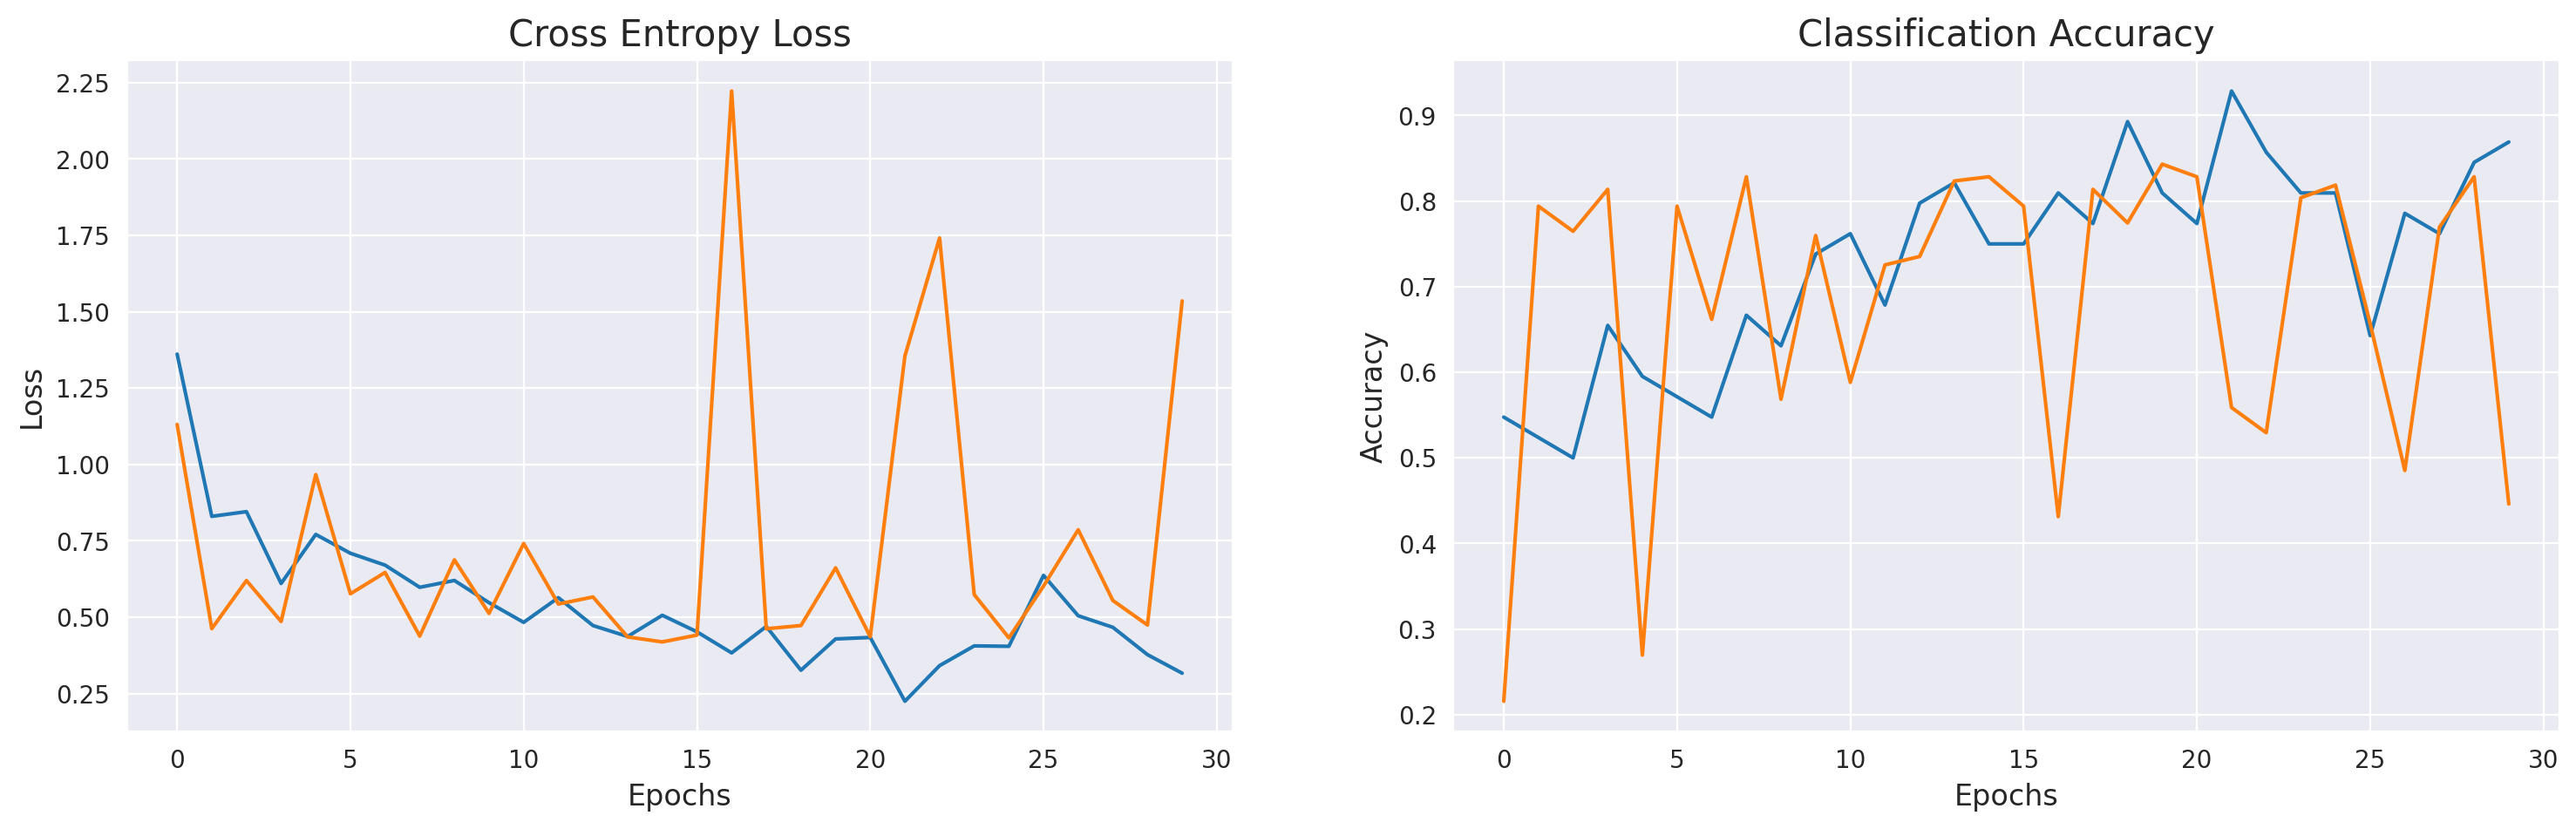

In [ ]:
error_vgg16 = pd.DataFrame(history_vgg16.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_vgg16['loss'])
plt.plot(error_vgg16['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_vgg16['accuracy'])
plt.plot(error_vgg16['val_accuracy'])

plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.553921568627451


In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Freeze layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Data directories and parameters
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

In [ ]:
# Create data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [ ]:
# Train the model
history_EfficientNetB7 = model.fit(train_gen,
                         validation_data=test_gen,
                         batch_size=64,
                         epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 505s 49s/step - accuracy: 0.5276 - loss: 0.7036 - val_accuracy: 0.7598 - val_loss: 0.6212
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 785ms/step - accuracy: 0.8249 - loss: 0.4187 - val_accuracy: 0.8431 - val_loss: 0.5140
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.9400 - loss: 0.3095 - val_accuracy: 0.8431 - val_loss: 0.4477
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.9945 - loss: 0.1929 - val_accuracy: 0.8382 - val_loss: 0.4038
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step - accuracy: 1.0000 - loss: 0.1140 - val_accuracy: 0.8382 - val_loss: 0.3773
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 889ms/step - accuracy: 0.9806 - loss: 0.1659 - val_accuracy: 0.8529 - val_loss: 0.3587
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 796ms/step - accuracy: 1.0000 - loss: 0.0866 - val_accuracy: 0.8529 - val_loss: 0.3449
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 939ms/step - accuracy: 1.0000 - loss: 0.0336 - val_accuracy: 0.8480 - val_loss:

In [ ]:
# Make predictions
result = model.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels
# Evaluate
loss, acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8028 - loss: 0.3916
The accuracy of the model for testing data is: 86.76470518112183
The Loss of the model for testing data is: 0.2839462161064148


In [ ]:
Er = []
np.append(history_EfficientNetB7, Er)

array([<keras.src.callbacks.history.History object at 0x7e19065fe510>],
      dtype=object)

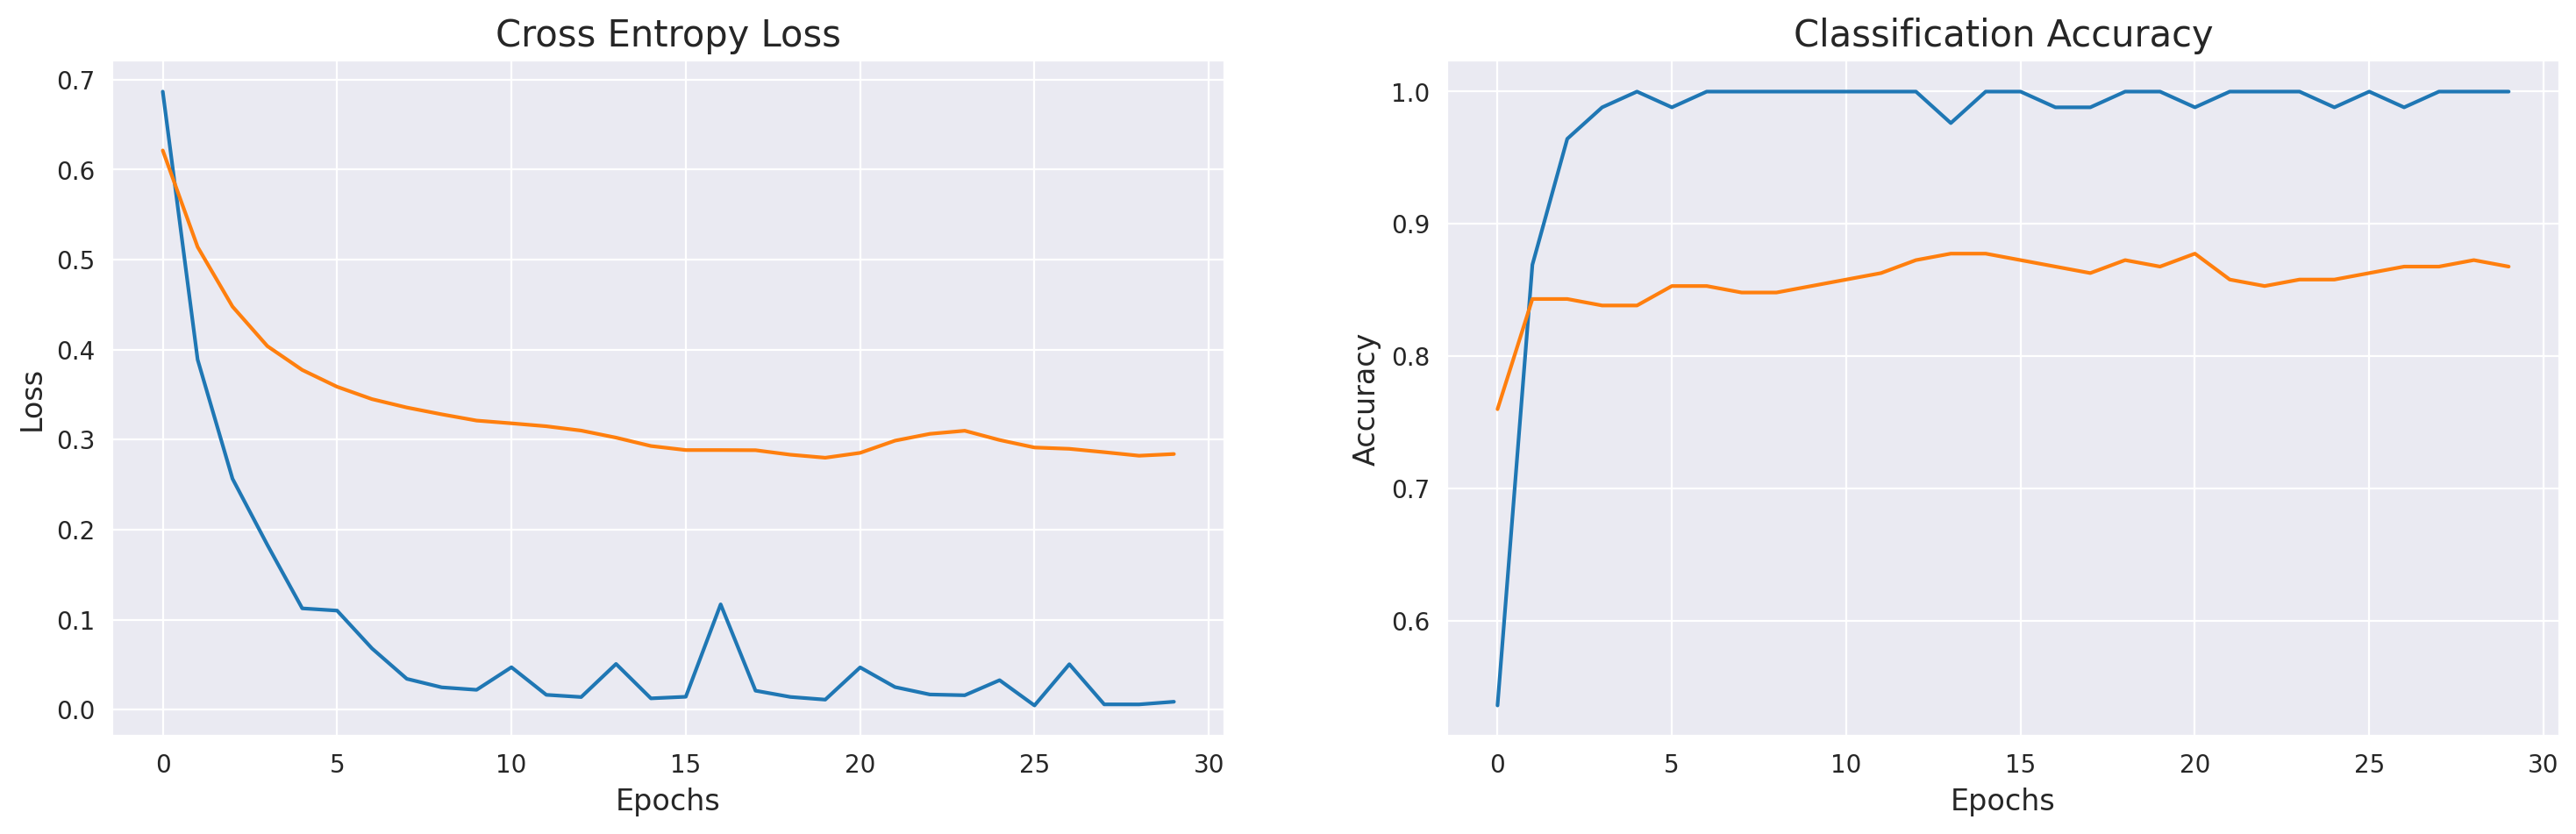

In [ ]:
error_EfficB7 = pd.DataFrame(history_EfficientNetB7.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_EfficB7['loss'])
plt.plot(error_EfficB7['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_EfficB7['accuracy'])
plt.plot(error_EfficB7['val_accuracy'])

plt.show()

# EfficientNetB7 and LSTM Model

# Extracted a Featuers

In [2]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
import os
from tqdm import tqdm

# Path to the image dataset directory
image_folder = "/content/drive/MyDrive/C1_data/Training"

# Load EfficientNetB7 model without top layers (used for feature extraction only)
# include_top=False removes classification head
# pooling='avg' adds global average pooling at the end
base_model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from a single image
def extract_features_from_image(image_path, target_size=(600, 600)):
    # Load and resize the image
    img = load_img(image_path, target_size=target_size)
    # Convert image to array
    img_array = img_to_array(img)
    # Expand dimensions to match model input
    img_array = np.expand_dims(img_array, axis=0)
    # Apply EfficientNetB7 preprocessing
    img_array = preprocess_input(img_array)
    # Extract features using the model
    features = base_model.predict(img_array)
    return features.flatten()

# Lists to hold extracted features and corresponding labels
features = []
labels = []

# Loop through each class folder and extract features from all images
for class_dir in os.listdir(image_folder):
    class_path = os.path.join(image_folder, class_dir)
    if os.path.isdir(class_path):
        for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_dir}"):
            img_path = os.path.join(class_path, img_file)
            try:
                feat = extract_features_from_image(img_path)
                features.append(feat)
                labels.append(class_dir)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Convert features and labels to NumPy arrays
X = np.array(features)  # Feature matrix
y = np.array(labels)    # Corresponding labels

print(f"Feature extraction completed.\nX shape: {X.shape}, y shape: {y.shape}")


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Processing Non_cancer:   0%|          | 0/42 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


Processing Non_cancer:   2%|▏         | 1/42 [00:19<13:32, 19.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Non_cancer:   5%|▍         | 2/42 [00:20<05:38,  8.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Non_cancer:   7%|▋         | 3/42 [00:20<03:09,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  10%|▉         | 4/42 [00:21<02:01,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  12%|█▏        | 5/42 [00:22<01:22,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  14%|█▍        | 6/42 [00:22<00:59,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  17%|█▋        | 7/42 [00:23<00:45,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  19%|█▉        | 8/42 [00:23<00:35,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  21%|██▏       | 9/42 [00:24<00:30,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Non_cancer:  24%|██▍       | 10/42 [00:24<00:25,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Non_cancer:  26%|██▌       | 11/42 [00:25<00:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Non_cancer:  29%|██▊       | 12/42 [00:26<00:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Non_cancer:  31%|███       | 13/42 [00:27<00:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  33%|███▎      | 14/42 [00:27<00:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Non_cancer:  36%|███▌      | 15/42 [00:28<00:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  38%|███▊      | 16/42 [00:28<00:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  40%|████      | 17/42 [00:29<00:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  43%|████▎     | 18/42 [00:29<00:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Non_cancer:  45%|████▌     | 19/42 [00:30<00:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  48%|████▊     | 20/42 [00:30<00:12,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Non_cancer:  50%|█████     | 21/42 [00:31<00:11,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  52%|█████▏    | 22/42 [00:31<00:10,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Non_cancer:  55%|█████▍    | 23/42 [00:32<00:10,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  57%|█████▋    | 24/42 [00:32<00:09,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  60%|█████▉    | 25/42 [00:33<00:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  62%|██████▏   | 26/42 [00:34<00:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Non_cancer:  64%|██████▍   | 27/42 [00:34<00:08,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Non_cancer:  67%|██████▋   | 28/42 [00:35<00:07,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  69%|██████▉   | 29/42 [00:35<00:06,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  71%|███████▏  | 30/42 [00:36<00:06,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Non_cancer:  74%|███████▍  | 31/42 [00:36<00:06,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Non_cancer:  76%|███████▌  | 32/42 [00:37<00:05,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Non_cancer:  79%|███████▊  | 33/42 [00:38<00:05,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Non_cancer:  81%|████████  | 34/42 [00:38<00:04,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Non_cancer:  83%|████████▎ | 35/42 [00:39<00:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Non_cancer:  86%|████████▌ | 36/42 [00:39<00:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  88%|████████▊ | 37/42 [00:40<00:02,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Non_cancer:  90%|█████████ | 38/42 [00:40<00:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  93%|█████████▎| 39/42 [00:41<00:01,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Non_cancer:  95%|█████████▌| 40/42 [00:41<00:01,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Non_cancer:  98%|█████████▊| 41/42 [00:42<00:00,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:   0%|          | 0/42 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:   2%|▏         | 1/42 [00:00<00:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:   5%|▍         | 2/42 [00:01<00:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Cancer:   7%|▋         | 3/42 [00:01<00:22,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Cancer:  10%|▉         | 4/42 [00:02<00:20,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  12%|█▏        | 5/42 [00:02<00:21,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  14%|█▍        | 6/42 [00:03<00:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Cancer:  17%|█▋        | 7/42 [00:04<00:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Cancer:  19%|█▉        | 8/42 [00:04<00:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Cancer:  21%|██▏       | 9/42 [00:05<00:19,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  24%|██▍       | 10/42 [00:05<00:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Cancer:  26%|██▌       | 11/42 [00:06<00:17,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Processing Cancer:  29%|██▊       | 12/42 [00:07<00:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Cancer:  31%|███       | 13/42 [00:07<00:17,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Cancer:  33%|███▎      | 14/42 [00:08<00:17,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Cancer:  36%|███▌      | 15/42 [00:08<00:14,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  38%|███▊      | 16/42 [00:09<00:14,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  40%|████      | 17/42 [00:10<00:14,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  43%|████▎     | 18/42 [00:10<00:14,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Cancer:  45%|████▌     | 19/42 [00:11<00:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  48%|████▊     | 20/42 [00:11<00:12,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Cancer:  50%|█████     | 21/42 [00:12<00:12,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  52%|█████▏    | 22/42 [00:12<00:11,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  55%|█████▍    | 23/42 [00:13<00:11,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  57%|█████▋    | 24/42 [00:13<00:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Cancer:  60%|█████▉    | 25/42 [00:14<00:09,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  62%|██████▏   | 26/42 [00:15<00:09,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  64%|██████▍   | 27/42 [00:15<00:08,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Cancer:  67%|██████▋   | 28/42 [00:16<00:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Cancer:  69%|██████▉   | 29/42 [00:16<00:07,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Cancer:  71%|███████▏  | 30/42 [00:17<00:06,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Cancer:  74%|███████▍  | 31/42 [00:17<00:06,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Cancer:  76%|███████▌  | 32/42 [00:18<00:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Cancer:  79%|███████▊  | 33/42 [00:19<00:05,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Cancer:  81%|████████  | 34/42 [00:19<00:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Cancer:  83%|████████▎ | 35/42 [00:20<00:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Cancer:  86%|████████▌ | 36/42 [00:21<00:03,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Cancer:  88%|████████▊ | 37/42 [00:21<00:02,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Cancer:  90%|█████████ | 38/42 [00:22<00:02,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  93%|█████████▎| 39/42 [00:22<00:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Cancer:  95%|█████████▌| 40/42 [00:23<00:01,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Cancer:  98%|█████████▊| 41/42 [00:23<00:00,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Cancer: 100%|██████████| 42/42 [00:24<00:00,  1.73it/s]

Feature extraction completed.
X shape: (84, 2560), y shape: (84,)


In [15]:
np.save('/content/drive/MyDrive/C1_data/X_features.npy', X)
np.save('/content/drive/MyDrive/C1_data/y_labels.npy', y)
print("Features and labels saved successfully.")

Features and labels saved successfully.


In [45]:
from sklearn.model_selection import train_test_split

# Load the features and labels
X = np.load('/content/drive/MyDrive/C1_data/X_features.npy')
y = np.load('/content/drive/MyDrive/C1_data/y_labels.npy')

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Save the validation data
np.save('/content/drive/MyDrive/C1_data/X_train.npy', X_train)  # Save training features
np.save('/content/drive/MyDrive/C1_data/y_train.npy', y_train)  # Save training labels
np.save('/content/drive/MyDrive/C1_data/X_val.npy', X_val)  # Save validation features
np.save('/content/drive/MyDrive/C1_data/y_val.npy', y_val)  # Save validation labels

# builing Moodels

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

class FeatureBasedTrainer:
    def __init__(self,
                 feature_dir='features',
                 lstm_units=256,
                 dense_units=128,
                 dropout_rate=0.5,
                 num_classes=3,
                 learning_rate=1e-4,
                 model_path='saved_lstm_model.h5'):

        self.feature_dir = feature_dir
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.model_path = model_path
        self.model = self._build_model()
        self.label_encoder = LabelEncoder() # Initialize LabelEncoder


    def _load_data(self, name):
            if name == 'train':
                X = np.load(os.path.join(self.feature_dir, 'X_train.npy'))  # Load training features
                y = np.load(os.path.join(self.feature_dir, 'y_train.npy'))  # Load training labels
            elif name == 'val':
                X = np.load(os.path.join(self.feature_dir, 'X_val.npy'))  # Load validation features
                y = np.load(os.path.join(self.feature_dir, 'y_val.npy'))  # Load validation labels
            else:
                raise ValueError(f"Invalid data name: {name}")

            # Fit label encoder on training data if it's the first call for training data
            if name == 'train' and not hasattr(self.label_encoder, 'classes_'):
                self.label_encoder.fit(y)

            # Encode labels using the fitted label encoder
            y = self.label_encoder.transform(y)

            # Reshape X to have the required dimensions (samples, timesteps, features)
            X = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape for LSTM input (samples, timesteps, features)

            y = to_categorical(y, num_classes=self.num_classes)
            return X, y
    def _build_model(self):
        model = Sequential([
            Bidirectional(LSTM(self.lstm_units, return_sequences=False),
                           input_shape=(1, 2560)),  # Update input shape
            Dropout(self.dropout_rate),
            Dense(self.dense_units, activation='relu'),
            Dropout(self.dropout_rate / 2),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, epochs=30, batch_size=32, patience=5):
        # Load features
        X_train, y_train = self._load_data('train')
        X_val, y_val = self._load_data('val')

        # Callbacks
        early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, verbose=1)

        # Train
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stop, checkpoint])
        return history

    def evaluate(self, feature_file='val'):
        X, y = self._load_data(feature_file)
        return self.model.evaluate(X, y)

    def save_model(self, path=None):
        path = path or self.model_path
        self.model.save(path)
        print(f"Model saved to {path}")

    def load_model(self, path=None):
        path = path or self.model_path
        self.model = tf.keras.models.load_model(path)
        print(f"Model loaded from {path}")

    def summary(self):
        self.model.summary()

    def plot_history(self, history):
        """Plots the training and validation accuracy and loss curves."""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

In [63]:
trainer = FeatureBasedTrainer(feature_dir='/content/drive/MyDrive/C1_data/', num_classes=3)
trainer.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 512)            │     5,769,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,835,267 (22.26 MB)

 Trainable params: 5,835,267 (22.26 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = trainer.train(epochs=30, patience=6)
trainer.evaluate()
trainer.save_model()

Epoch 1/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9688 - loss: 0.2178
Epoch 1: val_loss improved from inf to 0.27095, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.9581 - loss: 0.2316 - val_accuracy: 1.0000 - val_loss: 0.2709
Epoch 2/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9688 - loss: 0.2315
Epoch 2: val_loss improved from 0.27095 to 0.26488, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9165 - loss: 0.2723 - val_accuracy: 1.0000 - val_loss: 0.2649
Epoch 3/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9688 - loss: 0.2265
Epoch 3: val_loss improved from 0.26488 to 0.23901, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9734 - loss: 0.2232 - val_accuracy: 1.0000 - val_loss: 0.2390
Epoch 4/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9688 - loss: 0.1830
Epoch 4: val_loss improved from 0.23901 to 0.20803, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9240 - loss: 0.2348 - val_accuracy: 1.0000 - val_loss: 0.2080
Epoch 5/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9688 - loss: 0.2721
Epoch 5: val_loss improved from 0.20803 to 0.19103, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9581 - loss: 0.2463 - val_accuracy: 1.0000 - val_loss: 0.1910
Epoch 6/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9062 - loss: 0.2951
Epoch 6: val_loss improved from 0.19103 to 0.18306, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9083 - loss: 0.2828 - val_accuracy: 0.9412 - val_loss: 0.1831
Epoch 7/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9062 - loss: 0.2881
Epoch 7: val_loss improved from 0.18306 to 0.17636, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9083 - loss: 0.2615 - val_accuracy: 1.0000 - val_loss: 0.1764
Epoch 8/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9062 - loss: 0.3071
Epoch 8: val_loss improved from 0.17636 to 0.17583, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9083 - loss: 0.2845 - val_accuracy: 1.0000 - val_loss: 0.1758
Epoch 9/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9062 - loss: 0.2533
Epoch 9: val_loss did not improve from 0.17583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9425 - loss: 0.2284 - val_accuracy: 1.0000 - val_loss: 0.1904
Epoch 10/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9688 - loss: 0.2070
Epoch 10: val_loss did not improve from 0.17583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9734 - loss: 0.1884 - val_accuracy: 1.0000 - val_loss: 0.1912
Epoch 11/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.1885
Epoch 11: val_loss did not improve from 0.17583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9467 - loss: 0.2034 - val_accuracy: 1.0000 - val_loss: 0.1774
Epoch 12/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.1777
Epoch 12: val_loss improved from 0.17583 to 0.17347, saving mode

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9694 - loss: 0.1815 - val_accuracy: 1.0000 - val_loss: 0.1735
Epoch 13/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9375 - loss: 0.1799
Epoch 13: val_loss did not improve from 0.17347
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9389 - loss: 0.2046 - val_accuracy: 1.0000 - val_loss: 0.1823
Epoch 14/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9375 - loss: 0.1931
Epoch 14: val_loss did not improve from 0.17347
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9616 - loss: 0.1824 - val_accuracy: 1.0000 - val_loss: 0.1818
Epoch 15/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9375 - loss: 0.1485
Epoch 15: val_loss improved from 0.17347 to 0.16691, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9503 - loss: 0.1626 - val_accuracy: 1.0000 - val_loss: 0.1669
Epoch 16/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9688 - loss: 0.1691
Epoch 16: val_loss improved from 0.16691 to 0.15882, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9808 - loss: 0.1355 - val_accuracy: 1.0000 - val_loss: 0.1588
Epoch 17/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0969
Epoch 17: val_loss improved from 0.15882 to 0.14697, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9886 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.1470
Epoch 18/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.1580
Epoch 18: val_loss improved from 0.14697 to 0.13243, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9812 - loss: 0.1676 - val_accuracy: 1.0000 - val_loss: 0.1324
Epoch 19/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.1429
Epoch 19: val_loss improved from 0.13243 to 0.12456, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9694 - loss: 0.1394 - val_accuracy: 1.0000 - val_loss: 0.1246
Epoch 20/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9688 - loss: 0.1845
Epoch 20: val_loss improved from 0.12456 to 0.12296, saving model to saved_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9808 - loss: 0.1605 - val_accuracy: 1.0000 - val_loss: 0.1230
Epoch 21/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9688 - loss: 0.1254
Epoch 21: val_loss did not improve from 0.12296
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9620 - loss: 0.1504 - val_accuracy: 1.0000 - val_loss: 0.1269
Epoch 22/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9375 - loss: 0.1752
Epoch 22: val_loss did not improve from 0.12296
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9616 - loss: 0.1526 - val_accuracy: 1.0000 - val_loss: 0.1563
Epoch 23/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9375 - loss: 0.1206
Epoch 23: val_loss did not improve from 0.12296
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9616 - loss: 0.1167 - val_accuracy: 0.9412 - val_loss: 0.1889
Epoch 24/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0941
Epoch 24: val_loss did not improve from 0.12296
3/3 ━━━━━━━━━━━━━

Model saved to saved_lstm_model.h5


# plots

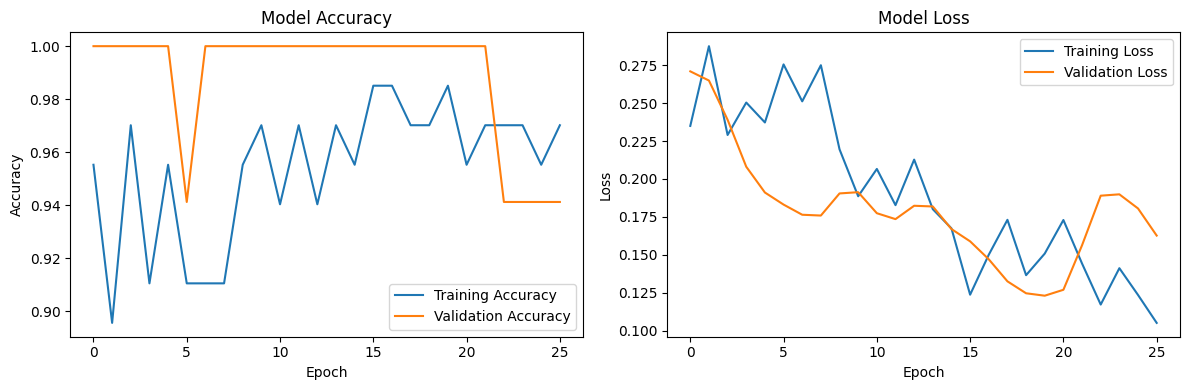

In [67]:
trainer.plot_history(history)

# Test and Plots images Prediction

Found 204 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model loaded from saved_lstm_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


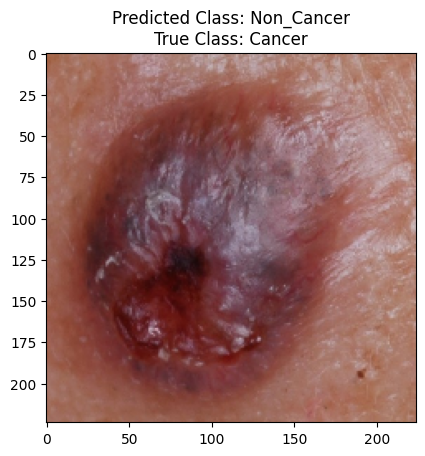

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


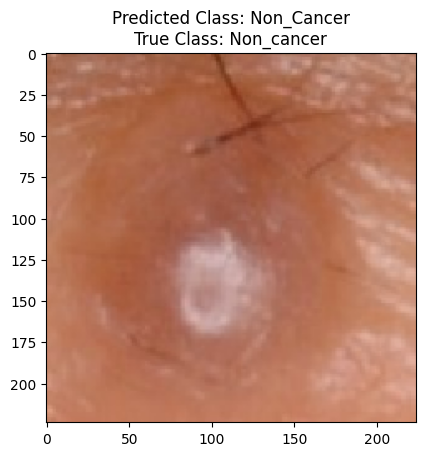

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


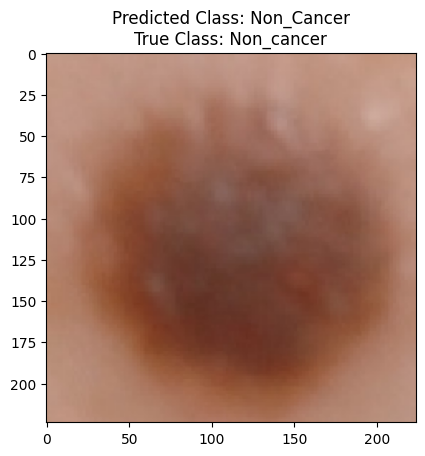

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


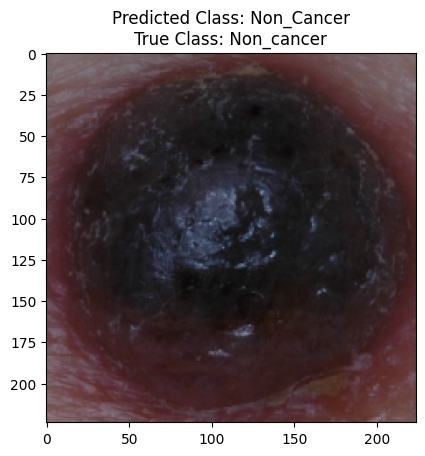

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


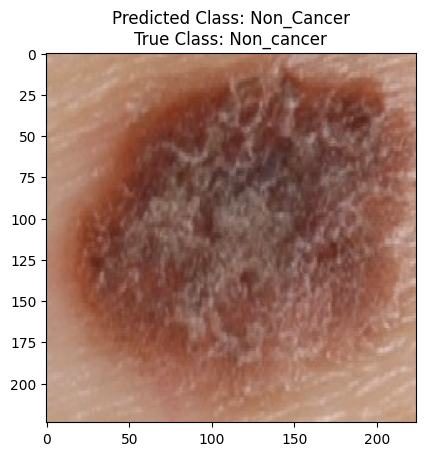

In [75]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Load the test data generator
test_data_dir = '/content/drive/MyDrive/C1_data/Testing'  # Update with your test data path
ts_gen = ImageDataGenerator(rescale=1./255)  # Normalize the test data
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=(224, 224), class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=1)

# Load the FeatureBasedTrainer model
trainer = FeatureBasedTrainer(feature_dir='/content/drive/MyDrive/C1_data/', num_classes=3)
trainer.load_model()  # Assuming you have already trained and saved the model

# Define class labels, should match num_classes in FeatureBasedTrainer
class_labels = ['benign', 'malignant', 'Non_Cancer']  # Updated class labels

# Get the indices for 5 random images
num_images_to_test = 5
random_indices = random.sample(range(len(test_gen)), num_images_to_test)


# Function to extract features from an image (same as before)
def extract_features_from_image(img_array, target_size=(600, 600)):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

# Loop through the random indices and display predictions
for i in random_indices:
    random_image, random_label = test_gen[i]
    features = extract_features_from_image(random_image[0])
    features = features.reshape(1, 1, features.shape[0])
    prediction = trainer.model.predict(features)[0]

    predicted_class = class_labels[np.argmax(prediction)]

    # Use original labels for true class to be consistent
    true_class = test_gen.class_indices  # defines dictionary {'class': index}
    classes = list(true_class.keys())  # defines list of dictionary's keys (classes), class names : string
    true_class = classes[np.argmax(random_label)]  # Access the true class label using the index

    accuracy = 1 if true_class == predicted_class else 0

    plt.imshow(random_image[0])
    plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}')
    plt.show()